# Наука о данных. Финальный проект

*2023-2024 учебный год*

**Автор:** *Лосевской Артём*

# Описание проекта

Кратко скажу здесь, что проект посвящён анализу спортивного плавания в российских регионах. Более подробную информацию можно найти в файле README.

Используемые библиотеки и инструменты:

1. Pandas
2. Scrapy
3. Re
4. Matplotlib
5. Numpy
6. Scikit-learn
7. Geopandas и Folium
8. SQL (SQLAlchemy)

# Часть 0. Необходимые приготовления

Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Часть 1. Парсинг данных

Соберем все данные по количеству бассейнов в каждом регионе. Для этого воспользуюсь сайтом Всероссийской Федерации Плавания. Скрепинг осуществлен с помощью scrapy — весь код в отдельном файле. 

Данные немного устаревшие (2019 год), но более свежих достоверных сведений по количеству бассейнов, в которых осуществляется сопртивная подготвока, не найти. Итого на 2019 год имеем данные по 85 субъектам:

In [2]:
pools = pd.read_json("pools_2019.json")
pools

region  50m  25m  total
0   Город федерального значения Москва   21  237    258
1                 Белгородская область    3   85     88
2                     Брянская область    1   11     12
3                 Владимирская область    1   36     37
4                  Воронежская область    2   44     46
..                                 ...  ...  ...    ...
80                Свердловская область    8   73     81
81                   Тюменская область    1   26     27
82                 Ханты-Мансийский АО    3   63     66
83                 Челябинская область    3   30     33
84                   Ямало-Ненецкий АО    1   29     30

[85 rows x 4 columns]

In [3]:
pools['region'].tolist()

['Город федерального значения Москва',
 'Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Воронежская область',
 'Ивановская область',
 'Калужская область',
 'Костромская область',
 'Курская область',
 'Липецкая область',
 'Московская область',
 'Орловская область',
 'Рязанская область',
 'Смоленская область',
 'Тамбовская область',
 'Тверская область',
 'Тульская область',
 'Ярославская область',
 'Город федерального значения Санкт-Петербург',
 'Архангельская область',
 'Вологодская область',
 'Калининградская область',
 'Ленинградская область',
 'Мурманская область',
 'Ненецкий автономный округ',
 'Новгородская область',
 'Псковская область',
 'Республика Карелия',
 'Республика Коми',
 'Астраханская область',
 'Волгоградская область',
 'Город федерального значения Севастополь',
 'Краснодарский край',
 'Республика Адыгея',
 'Республика Калмыкия',
 'Республика Крым',
 'Ростовская область',
 'Кабардино-Балкарская Республика',
 'Карачаево-Черкесская Республика',
 'Р

# Часть 2. Работа с датасетами

Загрузим датасет с населением России и полигонами для карты

In [4]:
import geopandas as gpd
regions_data = gpd.read_file("russia_regions_simplified.json")
regions_data

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...  
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...  
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...  
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...  
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...  
..                                                ...  
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...  
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...  
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...  
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...  
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...  

[85 rows x 4 columns]

<Axes: >

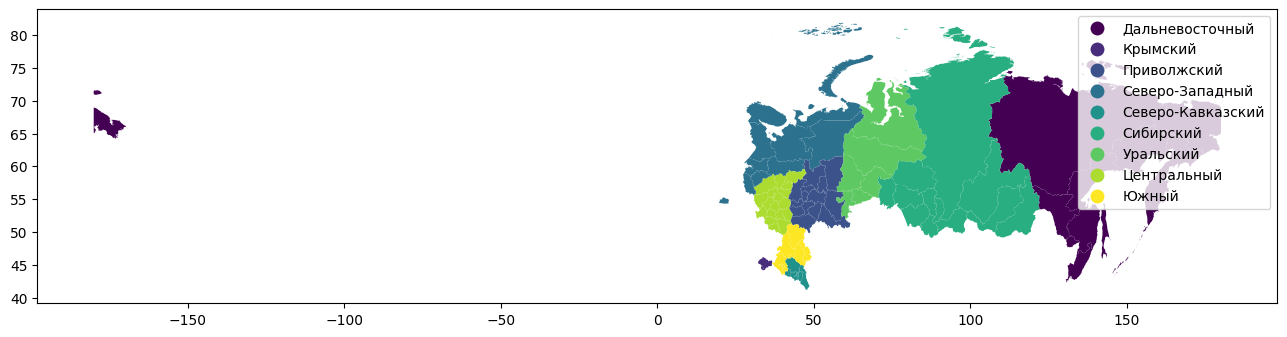

In [5]:
regions_data.plot(column = 'federal_district', legend = True, cmap = 'viridis', figsize=[16, 9])

В датасете я обнаружил 2 проблемы. 
- Во-первых, на нём есть Крымский федеральный округ (такой просуществовал в 2014-2016 годах). Севастополь и республику Крым нужно отнести к Южному ФО.
- Во-вторых, часть Чукотки оторвана от остальной России. Карту хорошо бы привести в нужную географическую систему отсчета. 

Займёмся этим:

In [6]:
regions_data[regions_data['federal_district'] == 'Крымский']

region federal_district  population  \
5   Республика Крым         Крымский     1916805   
26      Севастополь         Крымский      558273   

                                             geometry  
5   POLYGON ((33.69659 44.19104, 33.73574 44.18588...  
26  POLYGON ((33.69659 44.19104, 33.76178 44.38936...

In [7]:
li = regions_data[regions_data['federal_district'] == 'Крымский'].index.tolist()
regions_data.loc[li, 'federal_district'] = 'Южный'

regions_data_fot_plotting = regions_data.to_crs('EPSG:32646') #Исходная система отсчёта понадобится позже, когда начну работать с folium.

#Пробовал и просто перейти к этой системе отсчёта, но при работе с Folium возникали проблемы с геометрией

<Axes: >

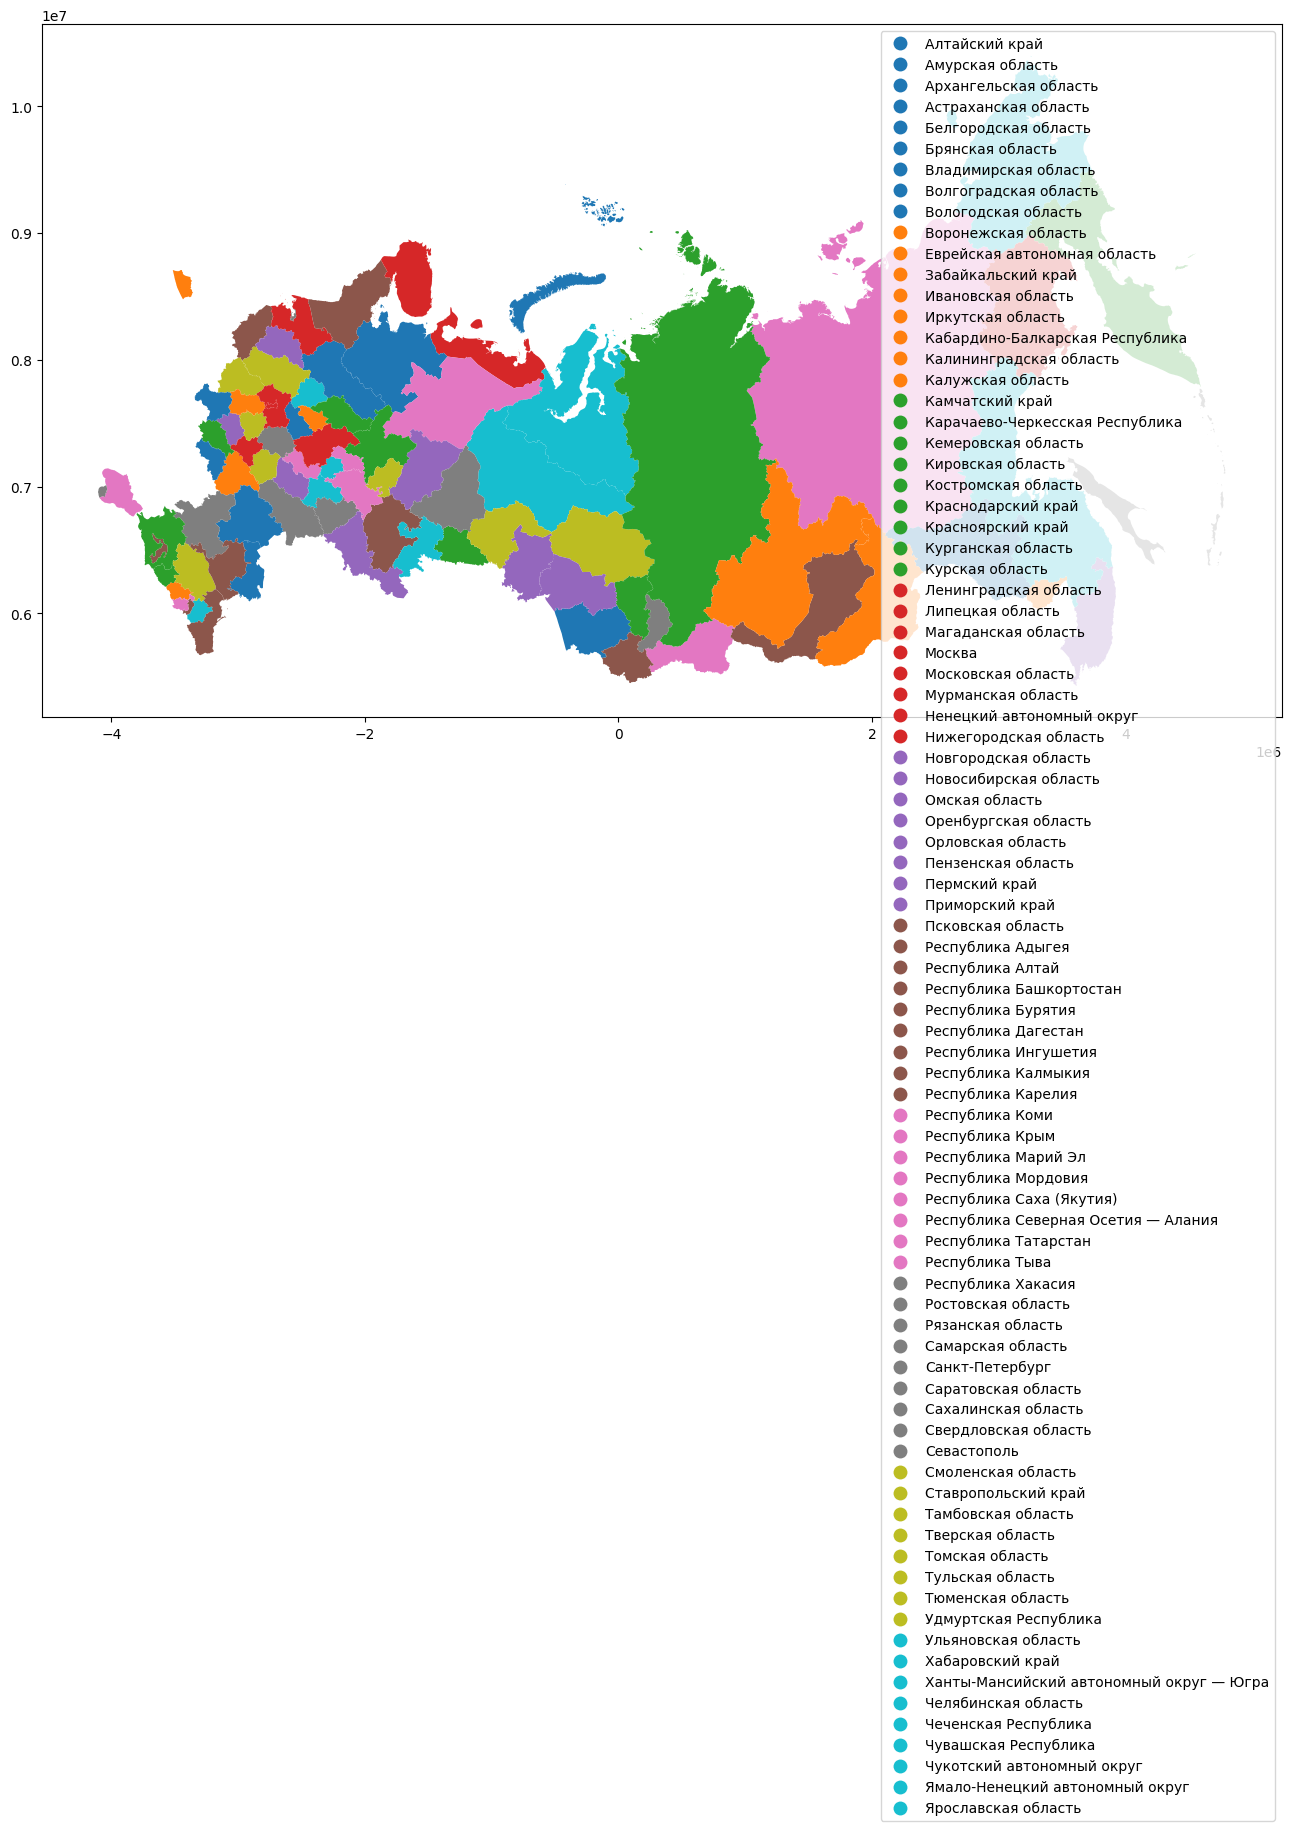

In [8]:
regions_data_fot_plotting.plot(column = 'region', legend = True, figsize=[16, 9])

<Axes: >

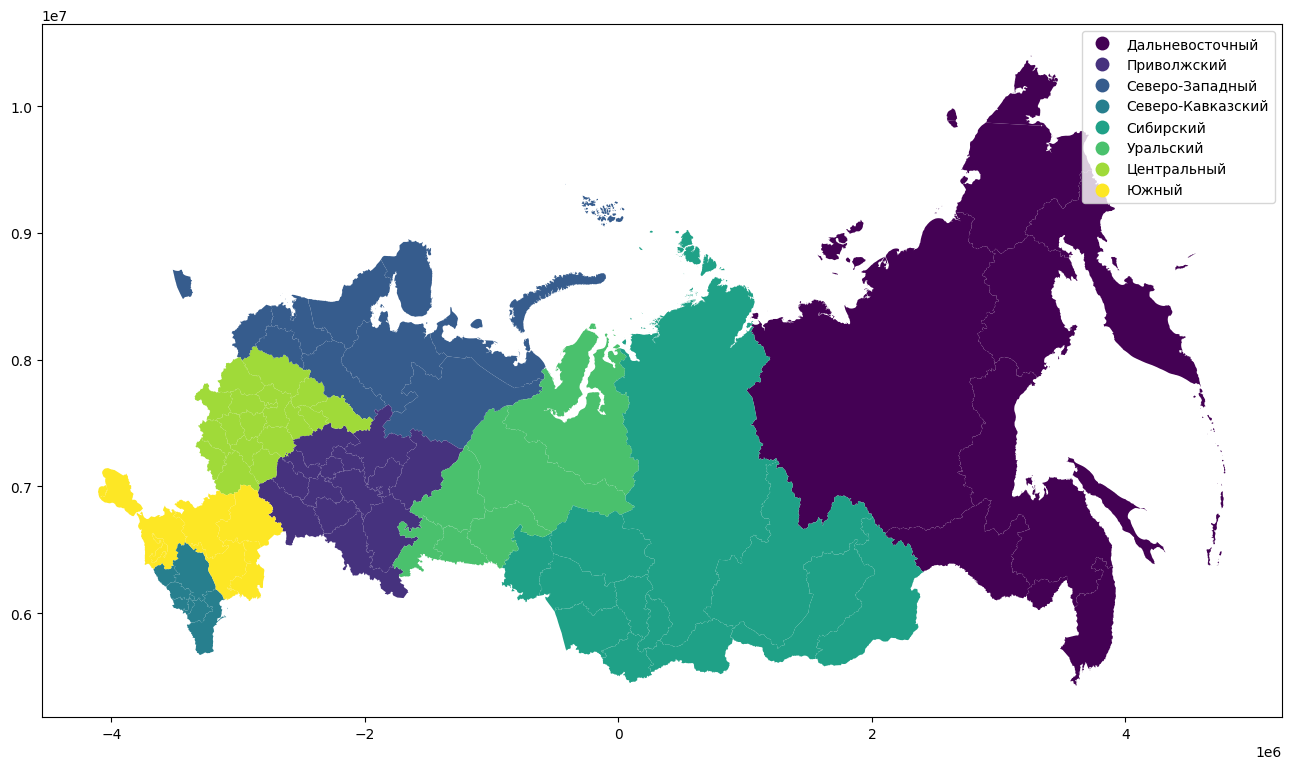

In [9]:
regions_data_fot_plotting.plot(column = 'federal_district', legend = True, cmap = 'viridis', figsize=[16, 9])

In [10]:
regions_data

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...  
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...  
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...  
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...  
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...  
..                                                ...  
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...  
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...  
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...  
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...  
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...  

[85 rows x 4 columns]

Карта не пострадала. Другая проблема — несоответствие имён некоторых регионов с датасетом, содержащим бассейны. Для их объединения надо бы привести всё к одному виду. 

Некоторые регионы называются в датасетах по-разному. Например, "Город федерального значения Москва" Придётся переименовать их вручную:

Избавлюсь от Город фед.значения в pools; заменю в regions_data и pools автономный округ (в обоих) и автономная область (это в regions_data) на АО. Югра — вручную.

In [11]:
pools['region'] = pools['region'].str.replace('Город федерального значения ', '')
pools['region'] = pools['region'].str.replace(' автономный округ', ' АО')
pools

region  50m  25m  total
0                 Москва   21  237    258
1   Белгородская область    3   85     88
2       Брянская область    1   11     12
3   Владимирская область    1   36     37
4    Воронежская область    2   44     46
..                   ...  ...  ...    ...
80  Свердловская область    8   73     81
81     Тюменская область    1   26     27
82   Ханты-Мансийский АО    3   63     66
83   Челябинская область    3   30     33
84     Ямало-Ненецкий АО    1   29     30

[85 rows x 4 columns]

In [12]:
regions_data['region'] = regions_data['region'].str.replace(' автономный округ', ' АО')
regions_data['region'] = regions_data['region'].str.replace(' автономная область', ' АО')
regions_data['region'] = regions_data['region'].str.replace('Ханты-Мансийский АО — Югра', 'Ханты-Мансийский АО')
regions_data[regions_data['region'].str.contains('АО')]

region federal_district  population  \
15  Ханты-Мансийский АО        Уральский     1730353   
17          Ненецкий АО  Северо-Западный       41383   
34         Еврейская АО  Дальневосточный      147458   
53    Ямало-Ненецкий АО        Уральский      512387   
77         Чукотский АО  Дальневосточный       47840   

                                             geometry  
15  POLYGON ((62.00044 65.71774, 61.96146 65.70520...  
17  MULTIPOLYGON (((53.99357 68.33912, 53.98577 68...  
34  POLYGON ((130.63129 48.88182, 130.66076 48.879...  
53  MULTIPOLYGON (((67.40769 68.76258, 67.39879 68...  
77  MULTIPOLYGON (((-172.65802 64.59757, -172.6221...

In [13]:
regions_pools = pd.merge(pools, regions_data, left_on = 'region', right_on = 'region', how = "inner")
regions_pools[regions_pools['region'].str.contains('АО')]

region  50m  25m  total federal_district  population  \
24          Ненецкий АО    0    1      1  Северо-Западный       41383   
68         Еврейская АО    0    2      2  Дальневосточный      147458   
77         Чукотский АО    0    4      4  Дальневосточный       47840   
81  Ханты-Мансийский АО    3   63     66        Уральский     1730353   
83    Ямало-Ненецкий АО    1   29     30        Уральский      512387   

                                             geometry  
24  MULTIPOLYGON (((53.99357 68.33912, 53.98577 68...  
68  POLYGON ((130.63129 48.88182, 130.66076 48.879...  
77  MULTIPOLYGON (((-172.65802 64.59757, -172.6221...  
81  POLYGON ((62.00044 65.71774, 61.96146 65.70520...  
83  MULTIPOLYGON (((67.40769 68.76258, 67.39879 68...

In [14]:
regions_pools

region  50m  25m  total federal_district  population  \
0                 Москва   21  237    258      Центральный    13104177   
1   Белгородская область    3   85     88      Центральный     1514527   
2       Брянская область    1   11     12      Центральный     1152505   
3   Владимирская область    1   36     37      Центральный     1325510   
4    Воронежская область    2   44     46      Центральный     2285282   
..                   ...  ...  ...    ...              ...         ...   
79  Свердловская область    8   73     81        Уральский     4239161   
80     Тюменская область    1   26     27        Уральский     1608494   
81   Ханты-Мансийский АО    3   63     66        Уральский     1730353   
82   Челябинская область    3   30     33        Уральский     3407145   
83     Ямало-Ненецкий АО    1   29     30        Уральский      512387   

                                             geometry  
0   MULTIPOLYGON (((37.04500 55.14220, 37.06439 55...  
1   POLYGON ((35.35099 50.97501, 35.33620 50.96316...  
2   POLYGON ((32.76293 53.42405, 32.75007 53.42686...  
3   POLYGON ((38.31813 56.65858, 38.31784 56.64228...  
4   POLYGON ((38.29261 51.96594, 38.31642 51.95749...  
..                                                ...  
79  POLYGON ((59.34846 61.66377, 59.35765 61.63435...  
80  POLYGON ((65.95016 58.61478, 65.98340 58.39356...  
81  POLYGON ((62.00044 65.71774, 61.96146 65.70520...  
82  POLYGON ((59.04205 56.16836, 59.06167 56.16549...  
83  MULTIPOLYGON (((67.40769 68.76258, 67.39879 68...  

[84 rows x 7 columns]

84, нужно 85. Еще есть проблема с Северной Осетией. Не выяснил, в чём именно. Просто заменю в pools:

In [15]:
regions_pools_test = pd.merge(pools, regions_data, left_on = 'region', right_on = 'region', how = "left")
regions_pools_test[regions_pools_test['population'].isnull()]

region  50m  25m  total federal_district  \
41  Республика Северная Осетия — Алания    2   18     20              NaN   

    population geometry  
41         NaN     None

In [16]:
pools[pools['region'] == 'Республика Северная Осетия — Алания']

Empty DataFrame
Columns: [region, 50m, 25m, total]
Index: []

In [17]:
regions_data[regions_data['region'] == 'Республика Северная Осетия — Алания']

region   federal_district  population  \
76  Республика Северная Осетия — Алания  Северо-Кавказский      680748   

                                             geometry  
76  POLYGON ((43.39849 42.89692, 43.41366 42.89161...

In [18]:
#need_replacement = pools[pools['region'].str.contains('Северная Осетия')]
pools.iloc[41, 0] = 'Республика Северная Осетия — Алания'

In [19]:
#pools['region'] = pools['region'].str.replace(' автономный округ', 'jct')
regions_pools = pd.merge(regions_data, pools, left_on = 'region', right_on = 'region', how = "inner")
regions_pools

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  50m  25m  total  
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37  
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...    2   65     67  
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...    1   16     17  
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...    0   15     15  
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...    1   31     32  
..                                                ...  ...  ...    ...  
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...    0   12     12  
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...    0   15     15  
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...    2   11     13  
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7  
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3  

[85 rows x 7 columns]

Теперь всё в порядке: имеем все (на 2019) 85 регионов.

# Часть 3.1. Анализ количества бассейнов в регионах

## Гипотеза

Первая гипотеза, которая приходит на ум после взгляда на имеющиеся данные (да в общем-то и без них тоже), это то, что количество бассейнов в регионе положительно зависит от численности населения.

Попробуем для начала отсортировать регионы по общему количеству бассейнов в них, а затем — по количеству пятидесяти метровых бассейнов.

## Визуализация

Имеем две переменные: население региона и количество бассейнов в нём. Независимой переменной будем считать население, а прогнозируемой переменной — количество бассейнов (общее количество, а также количество 50-метровых). В обоих случаях попробуем также задать линию тренда, то есть апроксимировать полиномом первой степени.

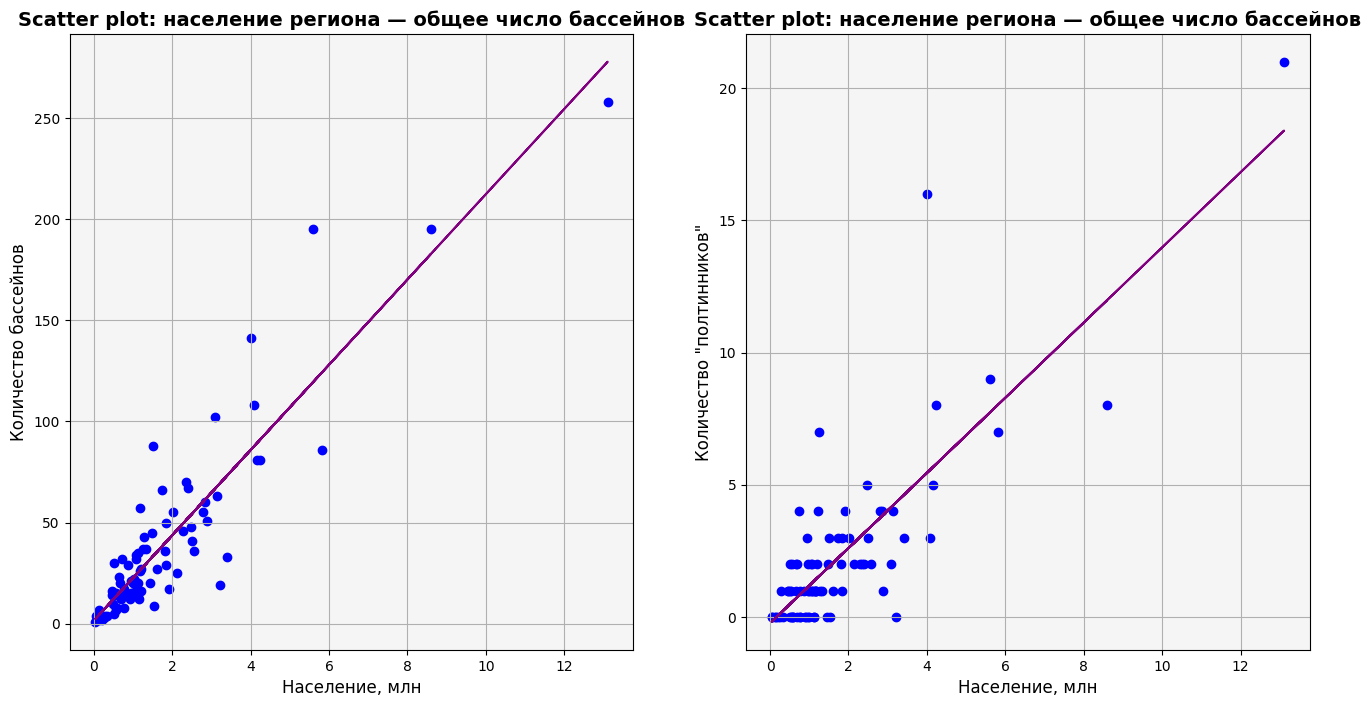

In [20]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
x = regions_pools['population'] / 1000000
y1, y2 = regions_pools['total'], regions_pools['50m']

ax1.scatter(x, y1, color = 'b')
ax1.set_xlabel('Население, млн', fontsize = 12)
ax1.set_ylabel('Количество бассейнов', fontsize = 12)
ax1.set_title('Scatter plot: население региона — общее число бассейнов', weight = 'bold', fontsize = 14)
ax1.set_facecolor('whitesmoke')
ax1.grid(True)
z = np.polyfit(regions_pools['population'] / 1000000, regions_pools['total'], 1)
p = np.poly1d(z)
ax1.plot(x, p(x), color = "purple")

ax2.scatter(x, y2, color = 'b')
ax2.set_xlabel('Население, млн', fontsize = 12)
ax2.set_ylabel('Количество "полтинников"', fontsize = 12)
ax2.set_title('Scatter plot: население региона — общее число бассейнов', weight = 'bold', fontsize = 14)
ax2.set_facecolor('whitesmoke')
ax2.grid(True)
z2 = np.polyfit(regions_pools['population'] / 1000000, regions_pools['50m'], 1)
p2 = np.poly1d(z2)
ax2.plot(x, p2(x), color = "purple")


Москва и Московская область очень отрываются от остальных по населению. А если их убрать? 

In [21]:
#Применим группировку по населению: отбросим регионы с населением более 6 млн человек. 
regions_pools_dropMoscowAndMO = regions_pools.loc[regions_pools['population'] <= 6000000]
#Так уж совпадает, что таких регионов всего два — Москва и Мос. область.
regions_pools_dropMoscowAndMO.sort_values('population', ascending = False)

region federal_district  population  \
42       Краснодарский край            Южный     5819345   
22          Санкт-Петербург  Северо-Западный     5600044   
70     Свердловская область        Уральский     4239161   
38       Ростовская область            Южный     4164547   
16  Республика Башкортостан      Приволжский     4077600   
..                      ...              ...         ...   
47         Республика Алтай        Сибирский      210769   
34             Еврейская АО  Дальневосточный      147458   
83      Магаданская область  Дальневосточный      134315   
77             Чукотский АО  Дальневосточный       47840   
17              Ненецкий АО  Северо-Западный       41383   

                                             geometry  50m  25m  total  
42  MULTIPOLYGON (((38.68584 46.87070, 38.64389 46...    7   79     86  
22  POLYGON ((29.64756 59.92983, 29.65653 59.91554...    9  186    195  
70  POLYGON ((59.34846 61.66377, 59.35765 61.63435...    8   73     81  
38  POLYGON ((40.13539 49.61710, 40.13941 49.59589...    5   76     81  
16  POLYGON ((53.69734 55.92508, 53.71937 55.92402...    3  105    108  
..                                                ...  ...  ...    ...  
47  POLYGON ((87.13270 52.61759, 87.09907 52.61923...    0    2      2  
34  POLYGON ((130.63129 48.88182, 130.66076 48.879...    0    2      2  
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7  
77  MULTIPOLYGON (((-172.65802 64.59757, -172.6221...    0    4      4  
17  MULTIPOLYGON (((53.99357 68.33912, 53.98577 68...    0    1      1  

[83 rows x 7 columns]

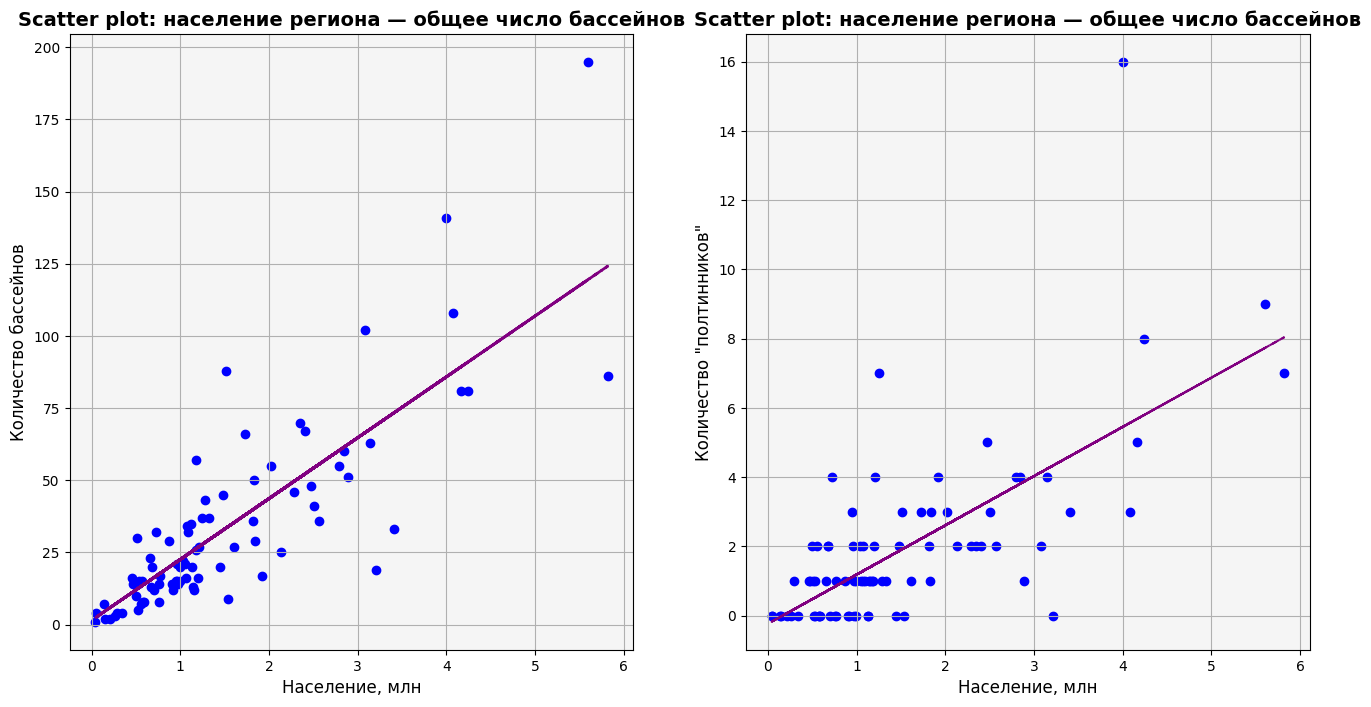

In [22]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
x = regions_pools_dropMoscowAndMO['population'] / 1000000
y1, y2 = regions_pools_dropMoscowAndMO['total'], regions_pools_dropMoscowAndMO['50m']

ax1.scatter(x, y1, color = 'b')
ax1.set_xlabel('Население, млн', fontsize = 12)
ax1.set_ylabel('Количество бассейнов', fontsize = 12)
ax1.set_title('Scatter plot: население региона — общее число бассейнов', weight = 'bold', fontsize = 14)
ax1.set_facecolor('whitesmoke')
ax1.grid(True)
z = np.polyfit(regions_pools['population'] / 1000000, regions_pools['total'], 1)
p = np.poly1d(z)
ax1.plot(x, p(x), color = "purple", linewidth = 2, linestyle = "dashed")

ax2.scatter(x, y2, color = 'b')
ax2.set_xlabel('Население, млн', fontsize = 12)
ax2.set_ylabel('Количество "полтинников"', fontsize = 12)
ax2.set_title('Scatter plot: население региона — общее число бассейнов', weight = 'bold', fontsize = 14)
ax2.set_facecolor('whitesmoke')
ax2.grid(True)
z2 = np.polyfit(regions_pools['population'] / 1000000, regions_pools['50m'], 1)
p2 = np.poly1d(z2)
ax2.plot(x, p2(x), color = "purple", linestyle = "dashed")


Вполне ожидаемо видим явный тренд на увеличение числа бассейнов по мере роста населения.

## Корелляции числа бассейнов и населения

Посмотрим, какова корелляция переменных:

In [23]:
regions_pools.sort_values('total', ascending = False)

region federal_district  population  \
24                   Москва      Центральный    13104177   
22          Санкт-Петербург  Северо-Западный     5600044   
66       Московская область      Центральный     8591736   
55     Республика Татарстан      Приволжский     4001625   
16  Республика Башкортостан      Приволжский     4077600   
..                      ...              ...         ...   
33          Республика Тыва        Сибирский      337271   
84      Республика Калмыкия            Южный      264483   
47         Республика Алтай        Сибирский      210769   
34             Еврейская АО  Дальневосточный      147458   
17              Ненецкий АО  Северо-Западный       41383   

                                             geometry  50m  25m  total  
24  MULTIPOLYGON (((37.04500 55.14220, 37.06439 55...   21  237    258  
22  POLYGON ((29.64756 59.92983, 29.65653 59.91554...    9  186    195  
66  POLYGON ((35.14850 55.95750, 35.15835 55.94636...    8  187    195  
55  MULTIPOLYGON (((47.29409 54.84787, 47.32211 54...   16  125    141  
16  POLYGON ((53.69734 55.92508, 53.71937 55.92402...    3  105    108  
..                                                ...  ...  ...    ...  
33  POLYGON ((88.79153 51.55376, 88.79379 51.53971...    0    4      4  
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3  
47  POLYGON ((87.13270 52.61759, 87.09907 52.61923...    0    2      2  
34  POLYGON ((130.63129 48.88182, 130.66076 48.879...    0    2      2  
17  MULTIPOLYGON (((53.99357 68.33912, 53.98577 68...    0    1      1  

[85 rows x 7 columns]

In [24]:
regions_pools.sort_values('50m', ascending = False)

region federal_district  population  \
24                Москва      Центральный    13104177   
55  Республика Татарстан      Приволжский     4001625   
22       Санкт-Петербург  Северо-Западный     5600044   
70  Свердловская область        Уральский     4239161   
66    Московская область      Центральный     8591736   
..                   ...              ...         ...   
59    Забайкальский край        Сибирский      992429   
58      Амурская область  Дальневосточный      756198   
47      Республика Алтай        Сибирский      210769   
48    Курганская область        Уральский      761586   
84   Республика Калмыкия            Южный      264483   

                                             geometry  50m  25m  total  
24  MULTIPOLYGON (((37.04500 55.14220, 37.06439 55...   21  237    258  
55  MULTIPOLYGON (((47.29409 54.84787, 47.32211 54...   16  125    141  
22  POLYGON ((29.64756 59.92983, 29.65653 59.91554...    9  186    195  
70  POLYGON ((59.34846 61.66377, 59.35765 61.63435...    8   73     81  
66  POLYGON ((35.14850 55.95750, 35.15835 55.94636...    8  187    195  
..                                                ...  ...  ...    ...  
59  POLYGON ((115.72983 56.96243, 115.69931 56.930...    0   15     15  
58  POLYGON ((119.85614 56.89608, 119.83205 56.889...    0   14     14  
47  POLYGON ((87.13270 52.61759, 87.09907 52.61923...    0    2      2  
48  POLYGON ((62.06106 56.13082, 62.14854 56.11632...    0    8      8  
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3  

[85 rows x 7 columns]

In [25]:
correlation = regions_pools['total'].corr(regions_pools['population'])
print(correlation)

0.909886466546183


In [26]:
correlation_50m = regions_pools['50m'].corr(regions_pools['population'])
print(correlation_50m)

0.826497179445957


Видим, что общая численность населения в регионе сильно положительно кореллирует с общим количеством бассейнов в нём, и несколько хуже — с количеством "полтинников".

## Предсказательная модель

Попробуем построить предсказательную модель числа бассейнов в регионе по количеству жителей в регионе. Для этого применим линейную регресиию и самый базовый метод оценки коэффициентов — метод наименьших квадратов.

Mean squared error (MSE):  587.31
Mean absolute error (MAE):  15.09
Coefficient of determination (R^2): 0.77


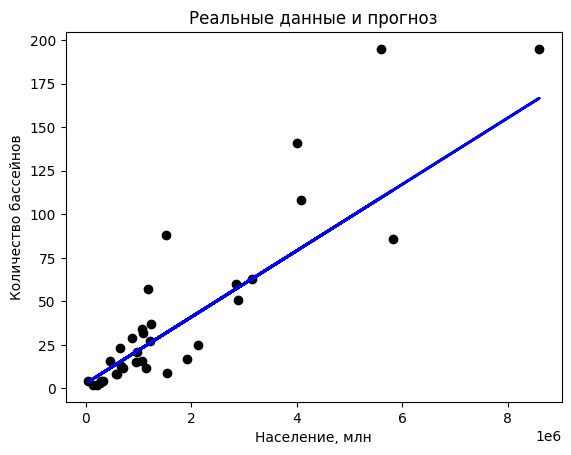

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

X = np.array(regions_pools['population']).reshape(-1, 1)
y = np.array(regions_pools['total'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Mean squared error (MSE):  %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE):  %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))

plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=2)
plt.xlabel("Население, млн")
plt.ylabel("Количество бассейнов")
plt.title("Реальные данные и прогноз")
plt.show()

Проведём аналогичную процедуру, но теперь без Москвы и МО (МО, как видно из графика, была в тестируемой выборке):

Mean squared error (MSE):  424.86
Mean absolute error (MAE):  13.27
Coefficient of determination (R^2): 0.70


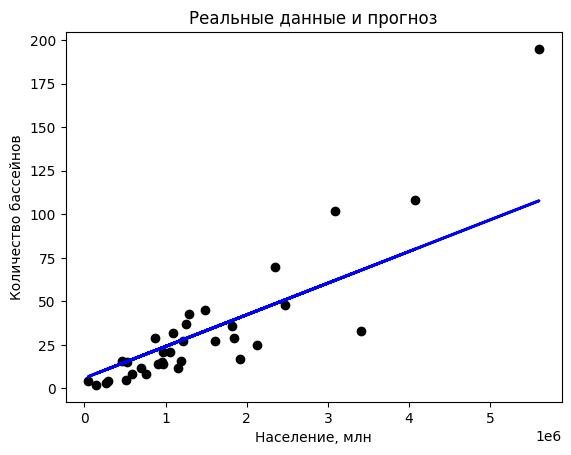

In [28]:
X = np.array(regions_pools_dropMoscowAndMO['population']).reshape(-1, 1)
y = np.array(regions_pools_dropMoscowAndMO['total'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Mean squared error (MSE):  %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE):  %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))

plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=2)
plt.xlabel("Население, млн")
plt.ylabel("Количество бассейнов")
plt.title("Реальные данные и прогноз")
plt.show()

Коэффициент детерминации заметно снизился, что несколько неожиданный результат. С другой стороны, Москва и МО были близки к прогнозируемым значениям (в отличии от крайних точек справа для датасета без Москвы и МО), поэтому такой результат тоже можно было допустить.

## Карта 1

Попробуем нанести на карту имеющуюся у нас информацию по числу бассейнов. Чем больше в регионе общее бассейнов, тем более тёплым будет цвет региона. 

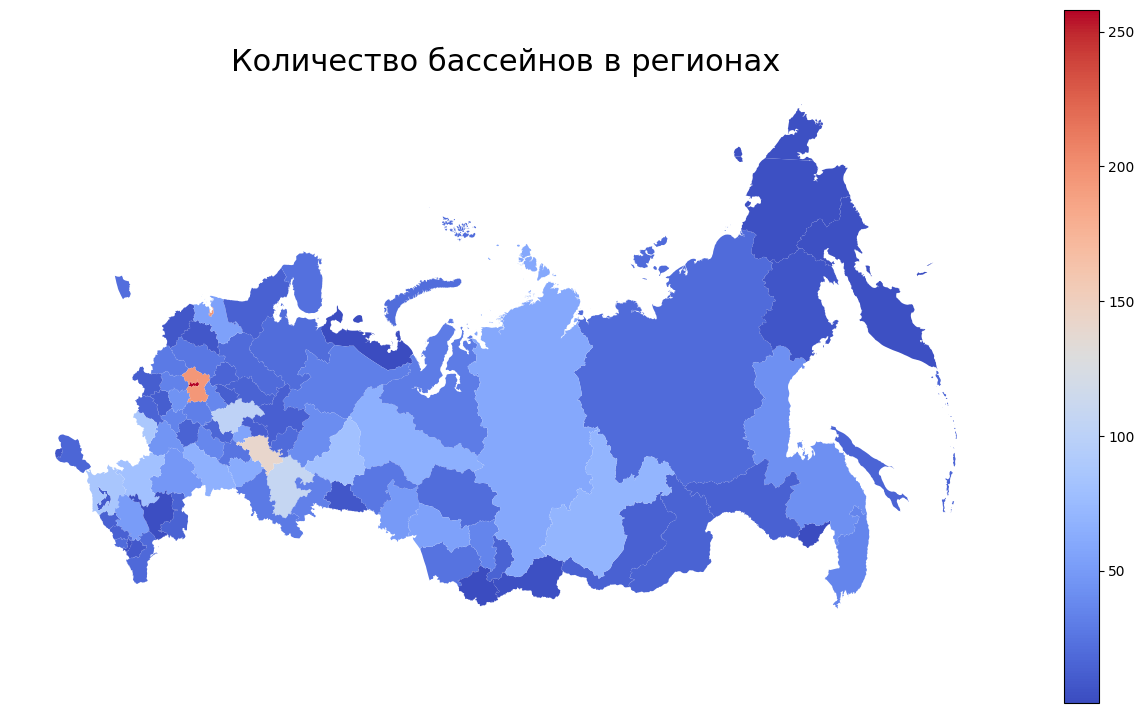

In [29]:
regions_pools_for_plotting = regions_pools.to_crs('EPSG:32646')

fig, ax = plt.subplots(figsize=[16, 9])
ax = regions_pools_for_plotting.plot(ax = ax, column = 'total', legend = True, cmap = 'coolwarm', figsize=[16, 9])

plt.title('Количество бассейнов в регионах', fontsize = 22)
ax.set_axis_off()

plt.show()

Откровенно говоря, информацию из такой карты почерпнуть сложно. Воспользуюсь folium

## Карта 2

Создадим с помощью folium интерактивную карту с палитрой цветов, что будет раскрашивать регион в зависимости от общего количества бассейнов. Также вынесем в посдказки информацию как об общем количестве бассейнов, так и о 50-метровых бассейнах в выбранном регионе.

In [30]:
import folium
import branca.colormap as cm

m = folium.Map(location=[64.6863136, 97.7453061], zoom_start=3)

max_count = regions_pools['total'].max()
min_count = regions_pools['total'].min()
colormap = cm.linear.YlGnBu_09.scale(min_count, max_count)
colormap.add_to(m)

def style_function(feature):
    regions_pools = feature['properties']['total']
    return {
        'fillColor': colormap(regions_pools),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

folium.GeoJson(
    regions_pools,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['region', 'total', '50m'],
        aliases=['Регион:', 'Количество бассейнов:', 'Количество "полтинников":'],
        localize=True
    )
).add_to(m)

m

# Часть 3.2. Анализ развития спортивного плавания в регионах

## Новый показатель и гипотеза

Знать, сколько бассейнов в регионе, хорошо и приятно. Однако куда интереснее было бы узнать, насколько разивто в регионе спортивное плавание. Здесь судить по одному лишь количеству бассейнов может быть некорректно.

До сих пор, собирая данные и проводя анализ количества бассейнов, я отдельно выделял "длинные" бассейны. Причина в том, что для нашего нынешнего анализа — анализа по части развитии спортивного плавания в регионе — бассейны длиной 50 метров могут быть более показтельны, потому что Олимпийские Игры проводится именно в 50-метровых бассейнах.

Добавим ещё один показатель: сколько жителей региона приходится на один бассейн. Своего рода плотность населения по бассейнам. И ещё один: сколько жителей региона приходится на один 50-метровый бассейн.

In [31]:
pd.options.display.float_format = '{:20.2f}'.format
regions_pools['pools_density'] = regions_pools['population'] / regions_pools['total']
regions_pools['50m_pools_density'] = regions_pools['population']  / regions_pools['50m']
regions_pools.replace(np.inf, 0, inplace = True)
regions_pools

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  50m  25m  total  \
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37   
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...    2   65     67   
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...    1   16     17   
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...    0   15     15   
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...    1   31     32   
..                                                ...  ...  ...    ...   
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...    0   12     12   
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...    0   15     15   
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...    2   11     13   
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7   
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3   

          pools_density    50m_pools_density  
0              33692.14            178087.00  
1              35894.69           1202472.00  
2              45374.88            771373.00  
3              64416.67                 0.00  
4              34028.69           1088918.00  
..                  ...                  ...  
80             76227.08                 0.00  
81             38126.67                 0.00  
82             51717.00            336160.50  
83             19187.86                 0.00  
84             88161.00                 0.00  

[85 rows x 9 columns]

*Впрочем, я передумал*. У такого показателя есть ряд недостатков.

Поступим наоборот: поделим число бассейнов на население. Получим что-то вроде плотности бассейнов. 

Такой показатель легче интерпретировать, но нужно задуматься о том, как его нормировать, ведь числа очень маленькие (действительно: смысл данного показтеля в том, чтобы показывать, сколько бассейнов приходится на 1 жителя региона). Например, домножим на 1.000.000, и тогда получим число, показывающее, сколько бассейнов приходится на 1 млн жителей в данном регионе.

In [32]:
regions_pools['pools_density'] = round(regions_pools['total'] / regions_pools['population'] * 100000, 2)
regions_pools['50m_pools_density'] = round(regions_pools['50m'] / regions_pools['population'] * 100000, 2)
regions_pools

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  50m  25m  total  \
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37   
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...    2   65     67   
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...    1   16     17   
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...    0   15     15   
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...    1   31     32   
..                                                ...  ...  ...    ...   
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...    0   12     12   
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...    0   15     15   
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...    2   11     13   
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7   
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3   

          pools_density    50m_pools_density  
0                  2.97                 0.56  
1                  2.79                 0.08  
2                  2.20                 0.13  
3                  1.55                 0.00  
4                  2.94                 0.09  
..                  ...                  ...  
80                 1.31                 0.00  
81                 2.62                 0.00  
82                 1.93                 0.30  
83                 5.21                 0.00  
84                 1.13                 0.00  

[85 rows x 9 columns]

Интуиция подсказывает, что чем больше это число, тем, должно быть, более комфортные условия для плавания и для его развития созданы в регионе. 
Попробуем посмотреть, где плотность бассейнов большего всего:

In [33]:
regions_pools.sort_values(by = 'pools_density', ascending = False)

region   federal_district  population  \
77          Чукотский АО    Дальневосточный       47840   
53     Ямало-Ненецкий АО          Уральский      512387   
45  Белгородская область        Центральный     1514527   
83   Магаданская область    Дальневосточный      134315   
30  Чувашская Республика        Приволжский     1173177   
..                   ...                ...         ...   
29  Республика Ингушетия  Северо-Кавказский      519078   
47      Республика Алтай          Сибирский      210769   
5        Республика Крым              Южный     1916805   
28  Чеченская Республика  Северо-Кавказский     1533209   
51   Республика Дагестан  Северо-Кавказский     3209781   

                                             geometry  50m  25m  total  \
77  MULTIPOLYGON (((-172.65802 64.59757, -172.6221...    0    4      4   
53  MULTIPOLYGON (((67.40769 68.76258, 67.39879 68...    1   29     30   
45  POLYGON ((35.35099 50.97501, 35.33620 50.96316...    3   85     88   
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7   
30  MULTIPOLYGON (((48.05063 54.98909, 48.10271 54...    1   56     57   
..                                                ...  ...  ...    ...   
29  POLYGON ((44.84761 43.56497, 44.82859 43.55179...    0    5      5   
47  POLYGON ((87.13270 52.61759, 87.09907 52.61923...    0    2      2   
5   POLYGON ((33.69659 44.19104, 33.73574 44.18588...    4   13     17   
28  POLYGON ((44.83243 43.68196, 44.84746 43.57817...    0    9      9   
51  MULTIPOLYGON (((45.70512 44.97736, 45.61347 44...    0   19     19   

          pools_density    50m_pools_density  
77                 8.36                 0.00  
53                 5.85                 0.20  
45                 5.81                 0.20  
83                 5.21                 0.00  
30                 4.86                 0.09  
..                  ...                  ...  
29                 0.96                 0.00  
47                 0.95                 0.00  
5                  0.89                 0.21  
28                 0.59                 0.00  
51                 0.59                 0.00  

[85 rows x 9 columns]

In [34]:
regions_pools.sort_values(by = '50m_pools_density', ascending = False)

region   federal_district  population  \
0     Пензенская область        Приволжский     1246609   
19       Республика Коми    Северо-Западный      726434   
14     Республика Адыгея              Южный      497985   
55  Республика Татарстан        Приволжский     4001625   
26           Севастополь              Южный      558273   
..                   ...                ...         ...   
47      Республика Алтай          Сибирский      210769   
25      Липецкая область        Центральный     1126263   
28  Чеченская Республика  Северо-Кавказский     1533209   
29  Республика Ингушетия  Северо-Кавказский      519078   
84   Республика Калмыкия              Южный      264483   

                                             geometry  50m  25m  total  \
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37   
19  POLYGON ((48.99979 66.11326, 48.99824 66.02301...    4   28     32   
14  POLYGON ((38.68402 44.95142, 38.75420 44.94944...    2    8     10   
55  MULTIPOLYGON (((47.29409 54.84787, 47.32211 54...   16  125    141   
26  POLYGON ((33.69659 44.19104, 33.76178 44.38936...    2    5      7   
..                                                ...  ...  ...    ...   
47  POLYGON ((87.13270 52.61759, 87.09907 52.61923...    0    2      2   
25  POLYGON ((37.86647 53.01222, 37.87520 52.99348...    0   35     35   
28  POLYGON ((44.83243 43.68196, 44.84746 43.57817...    0    9      9   
29  POLYGON ((44.84761 43.56497, 44.82859 43.55179...    0    5      5   
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3   

          pools_density    50m_pools_density  
0                  2.97                 0.56  
19                 4.41                 0.55  
14                 2.01                 0.40  
55                 3.52                 0.40  
26                 1.25                 0.36  
..                  ...                  ...  
47                 0.95                 0.00  
25                 3.11                 0.00  
28                 0.59                 0.00  
29                 0.96                 0.00  
84                 1.13                 0.00  

[85 rows x 9 columns]

Итак, у нас появилась новая метрика, но собственно показателя, прямо говорящего о спортивных достижениях региона в плавании у нас пока не было. Пора это исправить.

## Ещё парсинг: Мастера спорта России по плаванию

В качестве мерила успехов региона в спортивном плавании примем количество Мастеров спорта по плаванию в этом регионе. 

Для этого запарсим сайт, собирающий статистику и информацию по развитию спорта в России. Код паука scrapy, опять-таки, будет отдельным файлом, а здесь я просто выгружу полученный датасет:

In [35]:
masters = pd.read_json("MS_quant.json")
masters

region  ms_quant
0               Республика Адыгея         0
1         Республика Башкортостан        50
2              Республика Бурятия         3
3                Республика Алтай         0
4             Республика Дагестан         2
..                            ...       ...
84                Республика Крым        12
85              город Севастополь         4
86   Донецкая Народная Республика         1
87  Луганская Народная Республика         0
88             Херсонская область         0

[89 rows x 2 columns]

In [36]:
masters.sort_values(by = 'ms_quant', ascending = False)

region  ms_quant
77                     город Москва       602
78            город Санкт-Петербург       478
66             Свердловская область       199
34            Волгоградская область       156
50               Московская область       153
..                              ...       ...
7               Республика Калмыкия         0
6   Кабардино-Балкарская Республика         0
5              Республика Ингушетия         0
3                  Республика Алтай         0
88               Херсонская область         0

[89 rows x 2 columns]

В этом датасете имеем уже 89 регионов (таковы сегодняшние реалии). Уберём 4 новых региона: ДНР, ЛНР, Херсонскую и Запорожскую области. Вдобавок, придётся снова привести названия регионов к соответсвующим названиям в датасете regions_pools.

In [37]:
masters[masters['region'] == 'Запорожская область']

region  ms_quant
83  Запорожская область         0

In [38]:
masters.drop([88, 87, 86, 83], inplace = True)
masters

region  ms_quant
0                   Республика Адыгея         0
1             Республика Башкортостан        50
2                  Республика Бурятия         3
3                    Республика Алтай         0
4                 Республика Дагестан         2
..                                ...       ...
80  Ханты-Мансийский автономный округ        81
81         Чукотский автономный округ         0
82    Ямало-Ненецкий автономный округ        13
84                    Республика Крым        12
85                  город Севастополь         4

[85 rows x 2 columns]

In [39]:
masters['region'] = masters['region'].str.replace(' автономный округ', ' АО')
masters['region'] = masters['region'].str.replace(' автономная область', ' АО')
masters['region'] = masters['region'].str.replace('Ханты-Мансийский АО — Югра', 'Ханты-Мансийский АО')
masters[masters['region'].str.contains('АО')]
masters

region  ms_quant
0         Республика Адыгея         0
1   Республика Башкортостан        50
2        Республика Бурятия         3
3          Республика Алтай         0
4       Республика Дагестан         2
..                      ...       ...
80      Ханты-Мансийский АО        81
81             Чукотский АО         0
82        Ямало-Ненецкий АО        13
84          Республика Крым        12
85        город Севастополь         4

[85 rows x 2 columns]

In [40]:
regions_swimming_1 = pd.merge(regions_pools, masters, left_on = 'region', right_on = 'region', how = 'left')
regions_swimming_2 = pd.merge(regions_pools, masters, left_on = 'region', right_on = 'region', how = 'right')

In [41]:
regions_swimming_1[regions_swimming_1['ms_quant'].isna()]

region federal_district  population  \
22      Санкт-Петербург  Северо-Западный     5600044   
24               Москва      Центральный    13104177   
26          Севастополь            Южный      558273   
52  Кемеровская область        Сибирский     2568238   

                                             geometry  50m  25m  total  \
22  POLYGON ((29.64756 59.92983, 29.65653 59.91554...    9  186    195   
24  MULTIPOLYGON (((37.04500 55.14220, 37.06439 55...   21  237    258   
26  POLYGON ((33.69659 44.19104, 33.76178 44.38936...    2    5      7   
52  POLYGON ((84.45382 56.04315, 84.48310 56.01666...    2   34     36   

          pools_density    50m_pools_density  ms_quant  
22                 3.48                 0.16       NaN  
24                 1.97                 0.16       NaN  
26                 1.25                 0.36       NaN  
52                 1.40                 0.08       NaN

In [42]:
regions_swimming_2[regions_swimming_2['population'].isna()]

region federal_district  population geometry  50m  \
42  Кемеровская область — Кузбасс              NaN         NaN     None  NaN   
77                   город Москва              NaN         NaN     None  NaN   
78          город Санкт-Петербург              NaN         NaN     None  NaN   
84              город Севастополь              NaN         NaN     None  NaN   

    25m  total  pools_density  50m_pools_density  ms_quant  
42  NaN    NaN            NaN                NaN        51  
77  NaN    NaN            NaN                NaN       602  
78  NaN    NaN            NaN                NaN       478  
84  NaN    NaN            NaN                NaN         4

In [43]:
masters['region'] = masters['region'].str.replace('город ', '')
masters.at[42, 'region'] = 'Кемеровская область'

Теперь всё в порядке, все 85 субъектов с данными:

In [44]:
regions_swimming = pd.merge(regions_pools, masters, left_on = 'region', right_on = 'region', how = 'inner')
regions_swimming

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  50m  25m  total  \
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37   
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...    2   65     67   
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...    1   16     17   
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...    0   15     15   
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...    1   31     32   
..                                                ...  ...  ...    ...   
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...    0   12     12   
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...    0   15     15   
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...    2   11     13   
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7   
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3   

          pools_density    50m_pools_density  ms_quant  
0                  2.97                 0.56       126  
1                  2.79                 0.08        26  
2                  2.20                 0.13         6  
3                  1.55                 0.00         5  
4                  2.94                 0.09        16  
..                  ...                  ...       ...  
80                 1.31                 0.00        11  
81                 2.62                 0.00        13  
82                 1.93                 0.30        19  
83                 5.21                 0.00         8  
84                 1.13                 0.00         0  

[85 rows x 10 columns]

### Регионы с условно развитым плаванием

И новый показатель: количество Мастеров спорта по плаванию на 100 тысяч жителей региона. На основании этого показателя, если его значение будет не меньше среднего по России, будем считать регион имеющим развитое спортивное плавание. Объективных причин для такой кластеризации нет, но в нашем случае едва ли можно придумать объективный критерий в принципе.

In [45]:
regions_swimming['ms_density'] = round(regions_swimming['ms_quant'] / regions_swimming['population'] * 100000, 2)
regions_swimming

region federal_district  population  \
0    Пензенская область      Приволжский     1246609   
1   Саратовская область      Приволжский     2404944   
2   Республика Мордовия      Приволжский      771373   
3    Тамбовская область      Центральный      966250   
4     Рязанская область      Центральный     1088918   
..                  ...              ...         ...   
80   Ивановская область      Центральный      914725   
81  Костромская область      Центральный      571900   
82  Республика Марий Эл      Приволжский      672321   
83  Магаданская область  Дальневосточный      134315   
84  Республика Калмыкия            Южный      264483   

                                             geometry  50m  25m  total  \
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37   
1   POLYGON ((43.03971 52.37063, 43.03202 52.35811...    2   65     67   
2   POLYGON ((42.44266 54.82522, 42.40736 54.84237...    1   16     17   
3   POLYGON ((40.17000 53.31208, 40.15779 53.31251...    0   15     15   
4   MULTIPOLYGON (((38.66598 54.25671, 38.67116 54...    1   31     32   
..                                                ...  ...  ...    ...   
80  POLYGON ((40.43046 57.28583, 40.40419 57.26617...    0   12     12   
81  POLYGON ((40.93007 58.57634, 40.93801 58.56297...    0   15     15   
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...    2   11     13   
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7   
84  POLYGON ((43.71122 47.47423, 43.78674 47.35421...    0    3      3   

          pools_density    50m_pools_density  ms_quant           ms_density  
0                  2.97                 0.56       126                10.11  
1                  2.79                 0.08        26                 1.08  
2                  2.20                 0.13         6                 0.78  
3                  1.55                 0.00         5                 0.52  
4                  2.94                 0.09        16                 1.47  
..                  ...                  ...       ...                  ...  
80                 1.31                 0.00        11                 1.20  
81                 2.62                 0.00        13                 2.27  
82                 1.93                 0.30        19                 2.83  
83                 5.21                 0.00         8                 5.96  
84                 1.13                 0.00         0                 0.00  

[85 rows x 11 columns]

In [46]:
avg_ms_density = regions_swimming['ms_density'].mean()
avg_ms_density

2.200470588235295

In [47]:
developed_regions = regions_swimming[regions_swimming['ms_density'] >= avg_ms_density]
developed_regions.sort_values(by = 'ms_density', ascending = False)

region federal_district  population  \
0      Пензенская область      Приволжский     1246609   
22        Санкт-Петербург  Северо-Западный     5600044   
19        Республика Коми  Северо-Западный      726434   
72        Камчатский край  Дальневосточный      288730   
36  Волгоградская область            Южный     2470057   
83    Магаданская область  Дальневосточный      134315   
18  Архангельская область  Северо-Западный      964304   
64      Калужская область      Центральный     1070853   
25       Липецкая область      Центральный     1126263   
70   Свердловская область        Уральский     4239161   
15    Ханты-Мансийский АО        Уральский     1730353   
24                 Москва      Центральный    13104177   
79  Новосибирская область        Сибирский     2794266   
62  Нижегородская область      Приволжский     3081817   
75  Удмуртская Республика      Приволжский     1442251   
7     Ярославская область      Центральный     1194605   
57       Хабаровский край  Дальневосточный     1284090   
30   Чувашская Республика      Приволжский     1173177   
55   Республика Татарстан      Приволжский     4001625   
68      Красноярский край        Сибирский     2845545   
67      Кировская область      Приволжский     1138112   
23         Омская область        Сибирский     1832064   
45   Белгородская область      Центральный     1514527   
82    Республика Марий Эл      Приволжский      672321   
31    Сахалинская область  Дальневосточный      460535   
11   Новгородская область  Северо-Западный      575926   
53      Ямало-Ненецкий АО        Уральский      512387   
39      Самарская область      Приволжский     3142683   
63       Тульская область      Центральный     1481471   
10      Псковская область  Северо-Западный      587786   
20          Пермский край      Приволжский     2508352   
81    Костромская область      Центральный      571900   
38     Ростовская область            Южный     4164547   
40         Алтайский край        Сибирский     2130950   

                                             geometry  50m  25m  total  \
0   POLYGON ((42.14453 53.80234, 42.15405 53.77081...    7   30     37   
22  POLYGON ((29.64756 59.92983, 29.65653 59.91554...    9  186    195   
19  POLYGON ((48.99979 66.11326, 48.99824 66.02301...    4   28     32   
72  MULTIPOLYGON (((163.50254 58.46910, 163.49831 ...    1    3      4   
36  POLYGON ((42.88089 51.23303, 42.85534 51.24473...    5   43     48   
83  MULTIPOLYGON (((150.40425 59.57483, 150.41633 ...    0    7      7   
18  MULTIPOLYGON (((35.63596 64.96554, 35.63867 64...    2   19     21   
64  POLYGON ((35.33422 55.27175, 35.32089 55.25409...    1   33     34   
25  POLYGON ((37.86647 53.01222, 37.87520 52.99348...    0   35     35   
70  POLYGON ((59.34846 61.66377, 59.35765 61.63435...    8   73     81   
15  POLYGON ((62.00044 65.71774, 61.96146 65.70520...    3   63     66   
24  MULTIPOLYGON (((37.04500 55.14220, 37.06439 55...   21  237    258   
79  POLYGON ((76.09501 57.23553, 76.14025 57.11296...    4   51     55   
62  POLYGON ((41.79593 55.10367, 41.77552 55.10051...    2  100    102   
75  MULTIPOLYGON (((53.84267 56.61753, 53.85322 56...    0   20     20   
7   POLYGON ((37.62822 58.48294, 37.66512 58.45078...    2   14     16   
57  MULTIPOLYGON (((136.44575 54.62850, 136.46675 ...    1   42     43   
30  MULTIPOLYGON (((48.05063 54.98909, 48.10271 54...    1   56     57   
55  MULTIPOLYGON (((47.29409 54.84787, 47.32211 54...   16  125    141   
68  MULTIPOLYGON (((88.63451 55.31622, 88.65141 55...    4   56     60   
67  POLYGON ((47.07216 60.84448, 47.06348 60.81008...    1   12     13   
23  POLYGON ((75.10824 58.57624, 75.06885 58.55454...    1   49     50   
45  POLYGON ((35.35099 50.97501, 35.33620 50.96316...    3   85     88   
82  POLYGON ((46.72154 56.96339, 46.71764 56.97155...    2   11     13   
31  MULTIPOLYGON (((145.98748 43.36928, 146.00591 ...    1   15     16   
11  POLYGON ((29.89408 58.44575, 29.89993 58.42943...    0    8 

In [48]:
print(f"Согласно нашему критерию, в России {developed_regions['region'].count()} региона с развитым плаванием.")

Согласно нашему критерию, в России 34 региона с развитым плаванием.


## Визуализации и корреляции

Теперь у нас много данных и большое поле для действий.

- Во-первых, можно оценить взаимосвязь количества Мастеров спорта по плаванию в регионе (прогнозируемая переменная) с другими переменными (независимые переменные).

- Во-вторых, хорошо бы посмотреть, какие из перменных (население, бассейны 50 метров, общее число бассейнов, плотность бассейнов или плотность 50-метровых бассейнов) наиболее кореллируют с числом Мастеров спорта по плаванию в регионе.

- Наконец, круто было бы получить прогноз числа мастеров спорта, исходя из значимых перменных.

### 1) Население - МС по плаванию

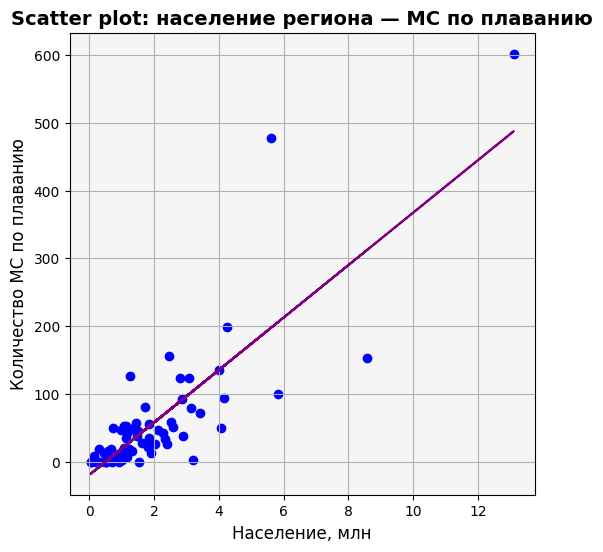

In [49]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
x = regions_swimming['population'] / 1000000
y = regions_swimming['ms_quant']

ax.scatter(x, y, color = 'b')
ax.set_xlabel('Население, млн', fontsize = 12)
ax.set_ylabel('Количество МС по плаванию', fontsize = 12)
ax.set_title('Scatter plot: население региона — МС по плаванию', weight = 'bold', fontsize = 14)
ax.set_facecolor('whitesmoke')
ax.grid(True)
z = np.polyfit(regions_swimming['population'] / 1000000, regions_swimming['ms_quant'], 1)
p = np.poly1d(z)
ax.plot(x, p(x), color = "purple")

In [50]:
correlation_ms_population = regions_swimming['ms_quant'].corr(regions_swimming['population'])
print(correlation_ms_population)

0.83270943053479


### 2) Бассейны - МС по плаванию

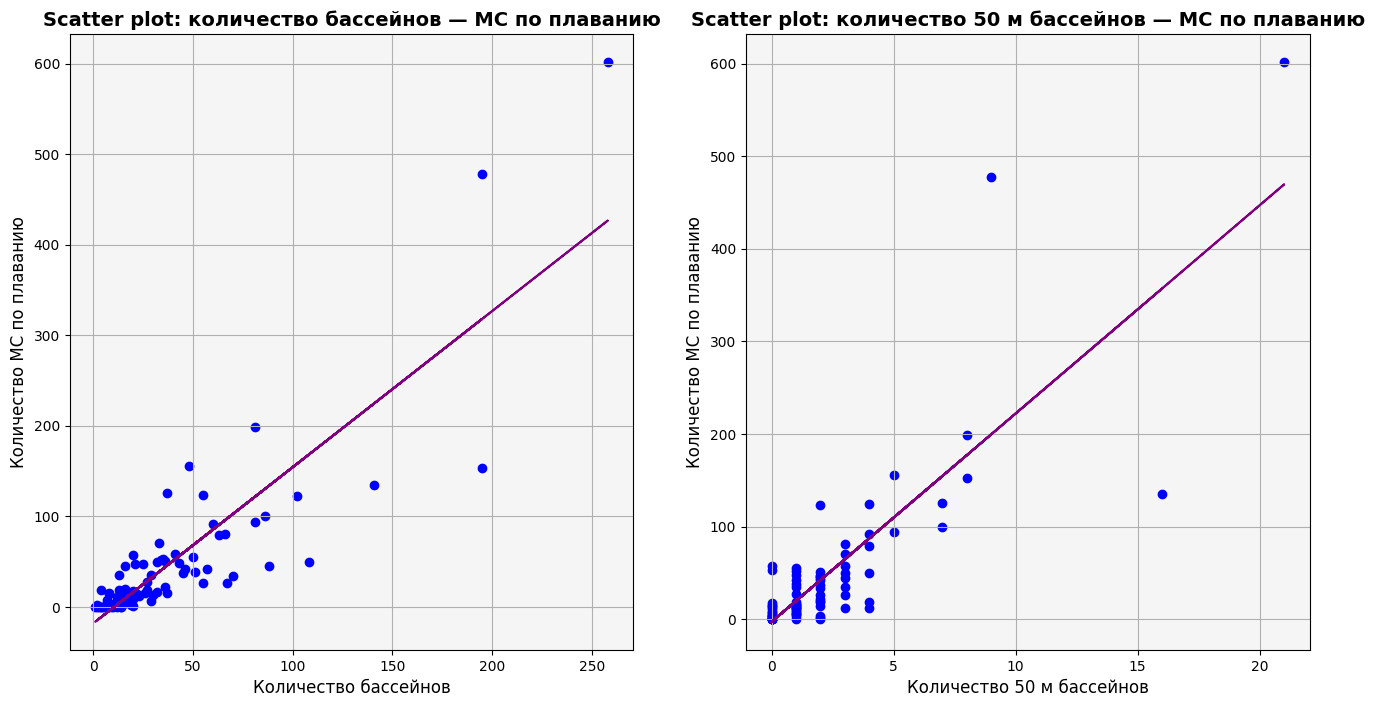

In [51]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
x1, x2 = regions_swimming['total'], regions_swimming['50m']
y = regions_swimming['ms_quant']

ax1.scatter(x1, y, color = 'b')
ax1.set_xlabel('Количество бассейнов', fontsize = 12)
ax1.set_ylabel('Количество МС по плаванию', fontsize = 12)
ax1.set_title('Scatter plot: количество бассейнов — МС по плаванию', weight = 'bold', fontsize = 14)
ax1.set_facecolor('whitesmoke')
ax1.grid(True)
z = np.polyfit(regions_swimming['total'], regions_swimming['ms_quant'], 1)
p = np.poly1d(z)
ax1.plot(x1, p(x1), color = "purple")

ax2.scatter(x2, y, color = 'b')
ax2.set_xlabel('Количество 50 м бассейнов', fontsize = 12)
ax2.set_ylabel('Количество МС по плаванию', fontsize = 12)
ax2.set_title('Scatter plot: количество 50 м бассейнов — МС по плаванию', weight = 'bold', fontsize = 14)
ax2.set_facecolor('whitesmoke')
ax2.grid(True)
z = np.polyfit(regions_swimming['50m'], regions_swimming['ms_quant'], 1)
p = np.poly1d(z)
ax2.plot(x2, p(x2), color = "purple")

In [52]:
correlation_ms_total = regions_swimming['ms_quant'].corr(regions_swimming['total'])
print(correlation_ms_total)

0.859432375506281


In [53]:
correlation_ms_50m = regions_swimming['ms_quant'].corr(regions_swimming['50m'])
print(correlation_ms_50m)

0.8325403898234356


### 3) Плотности - МС по плаванию

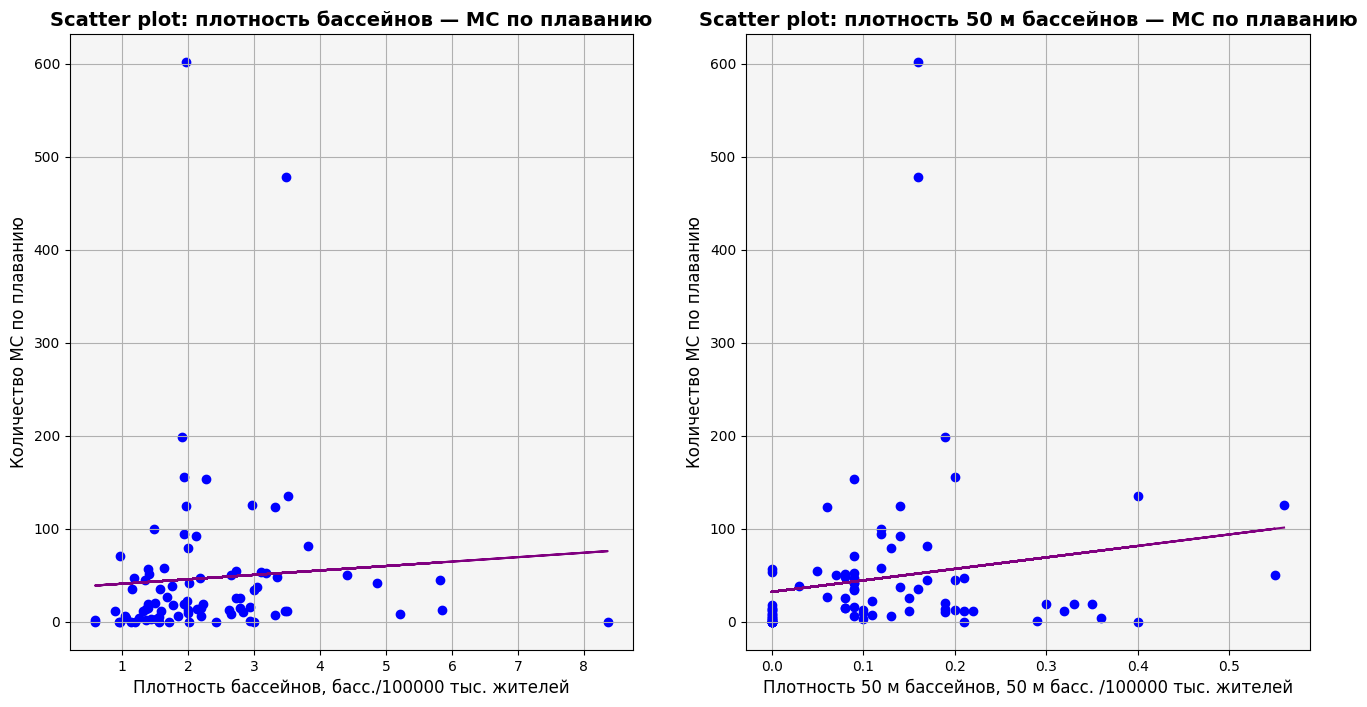

In [54]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
x1, x2 = regions_swimming['pools_density'], regions_swimming['50m_pools_density']
y = regions_swimming['ms_quant']

ax1.scatter(x1, y, color = 'b')
ax1.set_xlabel('Плотность бассейнов, басс./100000 тыс. жителей', fontsize = 12)
ax1.set_ylabel('Количество МС по плаванию', fontsize = 12)
ax1.set_title('Scatter plot: плотность бассейнов — МС по плаванию', weight = 'bold', fontsize = 14)
ax1.set_facecolor('whitesmoke')
ax1.grid(True)
z = np.polyfit(regions_swimming['pools_density'], regions_swimming['ms_quant'], 1)
p = np.poly1d(z)
ax1.plot(x1, p(x1), color = "purple")

ax2.scatter(x2, y, color = 'b')
ax2.set_xlabel('Плотность 50 м бассейнов, 50 м басс. /100000 тыс. жителей', fontsize = 12)
ax2.set_ylabel('Количество МС по плаванию', fontsize = 12)
ax2.set_title('Scatter plot: плотность 50 м бассейнов — МС по плаванию', weight = 'bold', fontsize = 14)
ax2.set_facecolor('whitesmoke')
ax2.grid(True)
z = np.polyfit(regions_swimming['50m_pools_density'], regions_swimming['ms_quant'], 1)
p = np.poly1d(z)
ax2.plot(x2, p(x2), color = "purple")

In [55]:
correlation_ms_density = regions_swimming['ms_quant'].corr(regions_swimming['pools_density'])
print(correlation_ms_density)

0.06875716475477722


In [56]:
correlation_ms_50m_density = regions_swimming['ms_quant'].corr(regions_swimming['50m_pools_density'])
print(correlation_ms_50m_density)

0.17205371450804638


Соберём корреляции в кучу:

In [57]:
correlations = regions_swimming[['ms_quant', 'population', 'total', '50m', 'pools_density', '50m_pools_density', 'ms_density']].corr()

correlations.style.format(precision=2)\
  .background_gradient(cmap='coolwarm')

### Промежуточный вывод

Выходит, что при анализе всех 85 регионов наиболее наибольшую корреляцию число Мастеров спорта имеет, как это ни банально, с общим числом бассейно в регионе. Даже немного грустно видеть такой результат, и особенно — видеть мизерную корреляцию с плотностью бассейнов. Ну да никто и не обещал, что сможем наблюдать связь с этим показателем.

Если мы выбираем плотность мастеров спорта как метрику, отражающую развитие региона в спортивном плавании, то сильной коррелиции не удаётся увидеть ни с каким из показателей, что тоже не самый радостный результат.

Думаю, что можно попробовать построить предсказтельную модель числа Мастеров спорта по плаванию на основании двух показателей: населения и общего числа бассейнов. 

### 4) Предсказательная модель

In [58]:
X = regions_swimming.loc[:, ['population', 'total']]
y = regions_swimming['ms_quant']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Mean squared error (MSE):  %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE):  %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))
print(f'Coefficients: {regr.coef_[0]:.5f}, {regr.coef_[1]:.5f}')

Mean squared error (MSE):  5628.48
Mean absolute error (MAE):  42.40
Coefficient of determination (R^2): 0.56
Coefficients: 0.00003, 0.76279


Модель даёт лишь уодвлетворительный результат: R^2 маловат. 

Коэффициент при численности населения почти нулевой, однако это неудивительно: размерность переменных совершенно разная, поэтому такой результат более чем адекватен.

In [ ]:
def predict_ms(population, pools):
    ms_quant = population * 0.00003 + pools * 0.76279
    return round(ms_quant)

population = int(input('Введите число жителей в вашем регионе:'))
pools = int(input('Введите число бассейнов в вашем регионе:'))
print(f'Предполагаемое число Мастеров Спорта по плаванию в регионе: {predict_ms(population, pools)}')

## Карта 

Теперь создадим карту на основании плотности Мастеров Спорта в регионе.

In [ ]:
m = folium.Map(location=[64.6863136, 97.7453061], zoom_start=3)

max_count = regions_swimming['ms_density'].max()
min_count = regions_swimming['ms_density'].min()
colormap = cm.linear.PuBuGn_09.scale(min_count, max_count)
colormap.add_to(m)

def style_function(feature):
    regions_swimming = feature['properties']['ms_density']
    return {
        'fillColor': colormap(regions_swimming),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

folium.GeoJson(
    regions_swimming,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['region', 'ms_quant', 'ms_density'],
        aliases=['Регион:', 'Количество МС по плаванию:', 'Число МС по плаванию на 100 тыс. жителей:'],
        localize=True,
    )
).add_to(m)

m

# Часть 4. SQL

Удалим столбец с геометрией: в базе данных он нам не понадобится.

In [ ]:
del regions_swimming['geometry']

In [ ]:
from sqlalchemy import create_engine

engine = create_engine("sqlite:///regions_swimming.db")
regions_swimming.to_sql('swimming_data', engine, if_exists='replace') 

In [ ]:
%load_ext sql

In [ ]:
%sql sqlite:///regions_swimming.db

Найдём топ-15 регионов по количеству МС по плаванию:

In [ ]:
%%sql
SELECT region, ms_quant 
FROM swimming_data 
ORDER BY ms_quant DESC
LIMIT 15

Теперь по плотности:

In [ ]:
%%sql
SELECT region, ms_density, ms_quant, total, population
FROM swimming_data 
ORDER BY ms_density DESC
LIMIT 5

Внезапно, Москвы здесь не оказалось, хотя есть Санкт-Петербург.

Посмотрим на статистику по федеральным округам:

In [ ]:
%%sql
SELECT federal_district, 
SUM(ms_quant) as sum_ms,
SUM(total) as sum_total_pools,
ROUND(AVG(ms_density), 2) as avg_ms_density, 
ROUND(AVG(ms_quant), 2) as avg_ms_quant, 
ROUND(AVG(total), 2) as avg_total_pools
FROM swimming_data 
GROUP BY federal_district
ORDER BY sum_ms DESC

Выберем те регионы, где число бассейнов и число МС больше среднего по России

In [ ]:
%%sql
SELECT ROUND(AVG(ms_quant), 2), ROUND(AVG(total), 2) FROM swimming_data

In [ ]:
%%sql
SELECT region, population, ms_quant, total as pools_quant FROM swimming_data
WHERE ms_quant > (SELECT AVG(ms_quant) FROM swimming_data) and  total > (SELECT AVG(total) FROM swimming_data)
ORDER BY population DESC

Наконец, посмотрим на топ-10 регионов, где наиболее эффективно развивается плавание, то есть в которых число Мастеров спорта на один бассейн региона наибольшее:

In [ ]:
%%sql
SELECT *, ROUND(ms_quant / CAST(total AS FLOAT), 2) AS efficiency FROM swimming_data
ORDER BY efficiency DESC
LIMIT 10

# Итоги

В результате анализа удалось прийти к изначально интуитивному выводу, что больше всего плавание развито там, где больше всего бассейнов. Но получены и несколько, по моему мнению, интересных результатов и любопытных наблюдений.

- Интересный вывод 1: в среднем на 100 тысяч жителей России приходится 2 Мастера спорта по плаванию.

- Интересный вывод 2: Пензенская область — абсолютный лидер по "плотности" Мастеров спорта по плаванию.

- Интересный вывод 3: во всех показателях, отнормированных по населению или по числу бассейнов (речь про "эффективность"), Санкт-Петербург опережает Москву.